In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

%reload_ext tensorboard


In [2]:
# load the data
(train_ds, val_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], 
                            shuffle_files=True, with_info=True)
# visualize a sample
#print(ds_info)
#tfds.show_examples(train_ds, ds_info)


# preprocess the data 
one_hot = lambda x: tf.one_hot(x, 10)
map_func = lambda x, y: (tf.cast(x, dtype=tf.float32)/255., # normalization
                            tf.cast(one_hot(y),tf.float32)) # make labels into one hot vectors
map_func_2 = lambda x: (x["image"],x["label"])
train_ds = train_ds.map(map_func_2).map(map_func).cache()
val_ds   = val_ds.map(map_func_2).map(map_func).cache()

# prepare the datasets
batch_size = 64
train_ds = train_ds.shuffle(4096).batch(batch_size)
val_ds   = val_ds.shuffle(4096).batch(batch_size)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

2022-12-07 21:30:45.365088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 21:30:45.367463: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
class ConvModel(tf.keras.Model):
    """
    The Convolutional Neural Network Model for the Classification of the CIFAR-10 dataset.

    It consists of 4 hidden layers and one output layer. The first 3 layers are convolutional,
    while the last hidden layer and the output layer are fully connected. On the output of
    each layer a Normalization and MaxPooling and Droput (apart from first layer) is performed.
    """
    def __init__(self):
        super().__init__()

        # convolutional hidden layer 1
        self.layer1 = tf.keras.Sequential()
        self.layer1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'))
        self.layer1.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))

        # convolutional hidden layer 2
        self.layer2 = tf.keras.Sequential()
        self.layer2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
        self.layer2.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))

        # convolutional hidden layer 3
        self.layer3 = tf.keras.Sequential()
        self.layer3.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
        self.layer3.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
        self.layer3.add(tf.keras.layers.Flatten())

        # fully connected output layer
        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.out(x)
        return x

In [14]:
# instantiate and compile model with its hyperparameters
model = ConvModel()
model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])

# build the model and show summary
model(tf.keras.Input((32,32,3)));
model.summary()

Model: "conv_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 16, 16, 32)        2432      
                                                                 
 sequential_10 (Sequential)  (None, 8, 8, 64)          18496     
                                                                 
 sequential_11 (Sequential)  (None, 2048)              73856     
                                                                 
 dense_2 (Dense)             multiple                  20490     
                                                                 
Total params: 115,274
Trainable params: 115,274
Non-trainable params: 0
_________________________________________________________________


In [15]:
#model.fit()

In [16]:
import datetime

def create_file_writers():
    """
    A function to create the log file writers for the Tensorboard.
    
    Returns:
        The log file writers for the training validation metrics respectively.
    """

    # Define where to save the log
    config_name= "config_name"
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"
    
    return tf.summary.create_file_writer(train_log_path), tf.summary.create_file_writer(val_log_path)

In [17]:
import pprint
import tqdm
import matplotlib.pyplot as plt


def training_loop(model, train_ds, val_ds, epochs):
    """
    A Function that trains a model on the training and validation data.

    It creates file writers to save the metrics for visualization 
    with the Tensorboard. Then it iterates over all epochs, performs
    a forward and backwardspass of the model with the training 
    and validation dataset and saves the respective performance metrics.

    Parameters:
        model (Model): The ANN model to be trained.
        train_ds (PrefetchDataset): The preprocessed training dataset.
        val_ds (PrefetchDataset): The preprocessed validation dataset.
    """
    # create file writers for Tensorboard
    train_summary_writer, val_summary_writer = create_file_writers()

    # create arrays for plot visualization of metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []   

    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        
        # Training:
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)
            
            # logging the validation metrics to the log file which is used by tensorboard
            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # store metrics for visualization
        train_losses.append(metrics["loss"])
        train_accuracies.append(metrics["accuracy"])

        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
        
        model.reset_metrics()    
        
        # Validation:
        for data in val_ds:
            metrics = model.test_step(data)
        
            # logging the validation metrics to the log file which is used by tensorboard
            with val_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        
        # store metrics for visualization
        val_losses.append(metrics["loss"])
        val_accuracies.append(metrics["accuracy"])
                    
        print([f"val_{key}: {value.numpy()}\n" for (key, value) in metrics.items()])

        model.reset_metrics()

    ## visualize performance

    # print the final loss and accuracy for testing different hyperparameters
    print("Final loss: ", val_losses[-1])
    print("Final accuracy: ", val_accuracies[-1])

    # Visualize accuracy and loss for training and test data.
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(val_losses)
    line3, = plt.plot(val_accuracies)
    line4, = plt.plot(train_accuracies)
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line4, line2, line3),("train loss", "train accuracy", "val loss", "val accuracy"))
    plt.show()

Epoch 0:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:47<00:00, 16.45it/s]


['loss: 1.4842758178710938', 'accuracy: 0.4670400023460388']
['val_loss: 1.256535530090332\n', 'val_accuracy: 0.5620999932289124\n']
Epoch 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:47<00:00, 16.59it/s]


['loss: 1.0841825008392334', 'accuracy: 0.6215199828147888']
['val_loss: 1.086085319519043\n', 'val_accuracy: 0.6187999844551086\n']
Epoch 2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:45<00:00, 17.06it/s]


['loss: 0.9230899810791016', 'accuracy: 0.6792399883270264']
['val_loss: 0.9050909280776978\n', 'val_accuracy: 0.6890000104904175\n']
Epoch 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:45<00:00, 17.26it/s]


['loss: 0.8137900829315186', 'accuracy: 0.7184399962425232']
['val_loss: 0.8819632530212402\n', 'val_accuracy: 0.6984999775886536\n']
Epoch 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:47<00:00, 16.50it/s]


['loss: 0.7356643080711365', 'accuracy: 0.7453600168228149']
['val_loss: 0.8318488001823425\n', 'val_accuracy: 0.7110000252723694\n']
Epoch 5:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:46<00:00, 16.70it/s]


['loss: 0.6724200248718262', 'accuracy: 0.768339991569519']
['val_loss: 0.8731158971786499\n', 'val_accuracy: 0.7053999900817871\n']
Epoch 6:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:46<00:00, 16.98it/s]


['loss: 0.6066218614578247', 'accuracy: 0.7916799783706665']
['val_loss: 0.8629268407821655\n', 'val_accuracy: 0.7129999995231628\n']
Epoch 7:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:47<00:00, 16.62it/s]


['loss: 0.5507315397262573', 'accuracy: 0.8098000288009644']
['val_loss: 0.9113527536392212\n', 'val_accuracy: 0.7120000123977661\n']
Epoch 8:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:45<00:00, 17.20it/s]


['loss: 0.4990929663181305', 'accuracy: 0.8274000287055969']
['val_loss: 0.8806155323982239\n', 'val_accuracy: 0.7213000059127808\n']
Epoch 9:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:44<00:00, 17.58it/s]


['loss: 0.45629069209098816', 'accuracy: 0.8409199714660645']
['val_loss: 0.923017680644989\n', 'val_accuracy: 0.7228999733924866\n']
Final loss:  tf.Tensor(0.9230177, shape=(), dtype=float32)
Final accuracy:  tf.Tensor(0.7229, shape=(), dtype=float32)


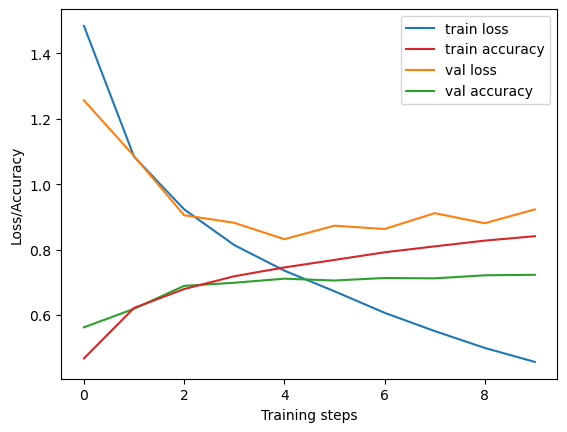

Training finished.


In [18]:
# run the training loop 
training_loop(model=model, 
              train_ds=train_ds, 
              val_ds=val_ds, 
              epochs=10
)
print("Training finished.")